In [11]:
# =========================
# IVF-PQ runner (multi-DIM) — FIXED + FAST
# - correct residual LUT per probed list (IMPORTANT!)
# - faster LUT via norms + matmul
# - per-dim configs (nprobe/cap/refine/trainN/nlist)
# Paste as ONE CELL.
# =========================
import json
from datetime import datetime
import numpy as np
import time
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple
from tqdm.auto import tqdm
from sklearn.cluster import MiniBatchKMeans

# ===== Run multiple dims here =====
DIMS = (100, 200, 300)
EVAL_KS = [1, 5, 10]

# These must match 0_data
N_BASE = 400_000
NQ_TOTAL = 100_000
NQ_TEST = 20_000
TOP_K_GT = 50
SEED = 42

# -------- IVF-PQ globals --------
PQ_M = None
PQ_NBITS = 8
KMEANS_MAX_ITER = 50
KMEANS_BATCH_SIZE = 8192

# ===== per-dim settings (you can tune) =====
DIM_CFG = {
    100: dict(nlist=2048, nprobe=8,  cap=2000,  refine=400,  trainN=100_000),
    200: dict(nlist=2048, nprobe=12, cap=6000,  refine=1200, trainN=150_000),
    300: dict(nlist=4096, nprobe=16, cap=12000, refine=2000, trainN=200_000),
}

REPO_ROOT = Path("..").resolve()
ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()
ARTIFACTS_RUNS.mkdir(parents=True, exist_ok=True)

print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)
print("DIMS:", DIMS, "| EVAL_KS:", EVAL_KS)
print("DIM_CFG:", DIM_CFG)


# ----------------------------
# Helpers: load + meta + strict single match
# ----------------------------
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _try_meta(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _require_one_match(pattern: str, dim: int) -> Path:
    matches = sorted(ARTIFACTS_DATA.glob(pattern))
    matches = [p for p in matches if f"glove{dim}d_" in p.name]
    if len(matches) != 1:
        names = [p.name for p in matches]
        raise FileNotFoundError(f"Expected exactly 1 match for dim={dim}, pattern={pattern}. Found: {names}")
    return matches[0]

def resolve_dataset_paths(dim: int) -> tuple[Path, Path, Path]:
    ds_glob = f"glove{dim}d_queries_N{N_BASE}_nq{NQ_TOTAL}_test{NQ_TEST}_seed{SEED}__ds*.npz"
    q_path = _require_one_match(ds_glob, dim)

    ds_suffix = q_path.name.split("__ds")[-1].replace(".npz", "")
    base_glob = f"glove{dim}d_base_N{N_BASE}__ds{ds_suffix}.npz"
    gt_glob = f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds{ds_suffix}.npz"

    base_path = _require_one_match(base_glob, dim)
    gt_path = _require_one_match(gt_glob, dim)
    return base_path, q_path, gt_path


# ----------------------------
# Metrics
# ----------------------------
def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        hits += len(set(pred_ids[i, :k].tolist()) & set(gt_ids[i, :k].tolist()))
    return float(hits) / float(denom) if denom > 0 else 0.0

def ms_per_query(seconds: float, nq: int) -> float:
    return 1000.0 * float(seconds) / float(max(1, nq))


# ----------------------------
# IVF-PQ index (correct + faster LUT)
# ----------------------------
@dataclass
class IVFPQIndex:
    d: int
    nlist: int
    nprobe: int
    M: int
    nbits: int
    use_residual: bool
    random_state: int

    centroids: Optional[np.ndarray] = None      # (nlist, d)
    codebooks: Optional[np.ndarray] = None      # (M, K, ds)
    cb_norm2: Optional[np.ndarray] = None       # (M, K)
    list_ids: Optional[List[np.ndarray]] = None
    list_codes: Optional[List[np.ndarray]] = None
    X_store: Optional[np.ndarray] = None

    def __post_init__(self):
        assert self.d % self.M == 0, "d must be divisible by M"
        assert self.nbits == 8, "nbits=8 only (uint8 codes)"
        self.ds = self.d // self.M
        self.K = 1 << self.nbits

    def train(self, X_train: np.ndarray, kmeans_max_iter: int, kmeans_batch_size: int):
        X_train = np.ascontiguousarray(X_train, dtype=np.float32)
        assert X_train.shape[1] == self.d

        km = MiniBatchKMeans(
            n_clusters=self.nlist,
            batch_size=kmeans_batch_size,
            random_state=self.random_state,
            n_init=3,
            max_iter=kmeans_max_iter,
        )
        labels = km.fit_predict(X_train)
        self.centroids = km.cluster_centers_.astype(np.float32)

        R = X_train - self.centroids[labels] if self.use_residual else X_train
        Rb = R.reshape(-1, self.M, self.ds)

        codebooks = np.empty((self.M, self.K, self.ds), dtype=np.float32)
        for m in tqdm(range(self.M), desc=f"Train PQ codebooks (M={self.M})"):
            km_m = MiniBatchKMeans(
                n_clusters=self.K,
                batch_size=kmeans_batch_size,
                random_state=self.random_state + 1000 + m,
                n_init=3,
                max_iter=kmeans_max_iter,
            )
            km_m.fit(Rb[:, m, :])
            codebooks[m] = km_m.cluster_centers_.astype(np.float32)

        self.codebooks = codebooks
        self.cb_norm2 = np.sum(codebooks * codebooks, axis=2, dtype=np.float32)  # (M,K)

        self.list_ids = [np.empty((0,), dtype=np.int64) for _ in range(self.nlist)]
        self.list_codes = [np.empty((0, self.M), dtype=np.uint8) for _ in range(self.nlist)]

    def _assign_lists_l2(self, X: np.ndarray) -> np.ndarray:
        C = self.centroids
        x2 = np.sum(X * X, axis=1, keepdims=True)
        c2 = np.sum(C * C, axis=1, keepdims=True).T
        dist = x2 + c2 - 2.0 * (X @ C.T)
        return np.argmin(dist, axis=1).astype(np.int32)

    def _pq_encode(self, R: np.ndarray) -> np.ndarray:
        Rb = R.reshape(-1, self.M, self.ds)
        N = Rb.shape[0]
        codes = np.empty((N, self.M), dtype=np.uint8)
        for m in range(self.M):
            W = self.codebooks[m]  # (K,ds)
            r = Rb[:, m, :]
            r2 = np.sum(r * r, axis=1, keepdims=True)
            w2 = np.sum(W * W, axis=1, keepdims=True).T
            dist = r2 + w2 - 2.0 * (r @ W.T)
            codes[:, m] = np.argmin(dist, axis=1).astype(np.uint8)
        return codes

    def add(self, X: np.ndarray, ids: Optional[np.ndarray] = None):
        X = np.ascontiguousarray(X, dtype=np.float32)
        N = X.shape[0]
        if ids is None:
            ids = np.arange(N, dtype=np.int64)
        else:
            ids = np.ascontiguousarray(ids, dtype=np.int64)
            assert ids.shape[0] == N

        self.X_store = X

        labels = self._assign_lists_l2(X)
        R = X - self.centroids[labels] if self.use_residual else X
        codes = self._pq_encode(R)

        order = np.argsort(labels, kind="mergesort")
        labels_s = labels[order]
        ids_s = ids[order]
        codes_s = codes[order]
        bounds = np.flatnonzero(np.r_[True, labels_s[1:] != labels_s[:-1], True])

        for a, b in zip(bounds[:-1], bounds[1:]):
            l = int(labels_s[a])
            self.list_ids[l] = np.concatenate([self.list_ids[l], ids_s[a:b]])
            self.list_codes[l] = np.concatenate([self.list_codes[l], codes_s[a:b]], axis=0)

    def _topnprobe_lists_l2(self, Q: np.ndarray) -> np.ndarray:
        C = self.centroids
        q2 = np.sum(Q * Q, axis=1, keepdims=True)
        c2 = np.sum(C * C, axis=1, keepdims=True).T
        dist = q2 + c2 - 2.0 * (Q @ C.T)
        return np.argpartition(dist, kth=self.nprobe - 1, axis=1)[:, :self.nprobe]

    # ---- FAST + CORRECT LUT for a given residual q_res (per list!) ----
    def _lookup_table(self, q_res: np.ndarray) -> np.ndarray:
        qb = q_res.reshape(self.M, self.ds).astype(np.float32, copy=False)          # (M,ds)
        qb_norm2 = np.sum(qb * qb, axis=1, dtype=np.float32)[:, None]              # (M,1)
        # dot: (M,K) = (M,ds) x (M,K,ds)
        dot = np.einsum("md,mkd->mk", qb, self.codebooks, optimize=True).astype(np.float32, copy=False)
        # dist = ||c||^2 + ||q||^2 - 2 q·c
        return (self.cb_norm2 + qb_norm2 - 2.0 * dot).astype(np.float32, copy=False)

    def search_batch(
        self,
        Q: np.ndarray,
        top_k: int,
        candidate_count: int,
        exclude_ids: Optional[list[int]],
        refine_r: int,
    ) -> Tuple[np.ndarray, np.ndarray]:
        Q = np.ascontiguousarray(Q, dtype=np.float32)
        nq = Q.shape[0]
        top_k = int(top_k)

        pred_ids = np.full((nq, top_k), -1, dtype=np.int32)
        pred_scores = np.full((nq, top_k), -np.inf, dtype=np.float32)

        probe_lists = self._topnprobe_lists_l2(Q)

        ex = None
        if exclude_ids is not None:
            ex = np.asarray(exclude_ids, dtype=np.int64)
            assert ex.shape[0] == nq

        m_idx = np.arange(self.M, dtype=np.int32)[:, None]

        for i in range(nq):
            q = Q[i]
            lists = probe_lists[i]

            cand_ids_list = []
            cand_dist_list = []

            # CORRECT: LUT per list (because residual differs per list centroid)
            for l in lists:
                l = int(l)
                ids_l = self.list_ids[l]
                codes_l = self.list_codes[l]
                if ids_l.size == 0:
                    continue

                q_res = (q - self.centroids[l]) if self.use_residual else q
                T = self._lookup_table(q_res)  # (M,K)

                dist_l = T[m_idx, codes_l.T].sum(axis=0).astype(np.float32, copy=False)
                cand_ids_list.append(ids_l)
                cand_dist_list.append(dist_l)

            if not cand_ids_list:
                continue

            cand_ids = np.concatenate(cand_ids_list)
            cand_dist = np.concatenate(cand_dist_list)

            if ex is not None:
                bad = (cand_ids == ex[i])
                if np.any(bad):
                    cand_dist = cand_dist.copy()
                    cand_dist[bad] = np.inf

            # cap candidates (main speed knob)
            if candidate_count and candidate_count > 0 and cand_dist.size > candidate_count:
                jj = np.argpartition(cand_dist, kth=candidate_count - 1)[:candidate_count]
                cand_ids = cand_ids[jj]
                cand_dist = cand_dist[jj]

            # shortlist
            R = min(int(refine_r) if refine_r and refine_r > top_k else top_k, cand_dist.size)
            topR = np.argpartition(cand_dist, kth=R - 1)[:R]
            idsR = cand_ids[topR]

            if refine_r and refine_r > 0:
                Xc = self.X_store[idsR.astype(np.int64, copy=False)]
                diff = Xc - q[None, :]
                dist_exact = np.sum(diff * diff, axis=1, dtype=np.float32)

                kk = min(top_k, dist_exact.size)
                sel = np.argpartition(dist_exact, kth=kk - 1)[:kk]
                idsK = idsR[sel].astype(np.int32, copy=False)
                dK = dist_exact[sel]
            else:
                distR = cand_dist[topR]
                kk = min(top_k, distR.size)
                sel = np.argpartition(distR, kth=kk - 1)[:kk]
                idsK = idsR[sel].astype(np.int32, copy=False)
                dK = distR[sel].astype(np.float32, copy=False)

            order = np.argsort(dK)
            pred_ids[i, :kk] = idsK[order]
            pred_scores[i, :kk] = (-dK[order]).astype(np.float32, copy=False)

        return pred_ids, pred_scores


def choose_M(d: int) -> int:
    if d == 50:  return 25
    if d == 100: return 25
    if d == 200: return 50
    if d == 300: return 75
    for M in [96, 80, 75, 64, 60, 50, 48, 40, 32, 25, 20, 16, 10]:
        if d % M == 0:
            return M
    raise ValueError("No suitable M")


def run_one_dim(dim: int):
    cfg = DIM_CFG[int(dim)]
    nlist = int(cfg["nlist"])
    nprobe = int(cfg["nprobe"])
    cap = int(cfg["cap"])
    refine_r = int(cfg["refine"])
    trainN = int(cfg["trainN"])

    print("\n" + "=" * 90)
    print(f"IVF-PQ RUN | dim={dim} | nlist={nlist} nprobe={nprobe} cap={cap} refine={refine_r} trainN={trainN}")
    print("=" * 90)

    base_path, queries_path, gt_path = resolve_dataset_paths(dim)
    base_z = _load_npz(base_path)
    queries_z = _load_npz(queries_path)
    gt_z = _load_npz(gt_path)

    ds_q = str(queries_z.get("dataset_id", _try_meta(queries_z).get("dataset_id", "")))
    if not ds_q:
        raise RuntimeError("Missing dataset_id in queries.")
    if str(base_z.get("dataset_id", _try_meta(base_z).get("dataset_id", ""))) != ds_q:
        raise RuntimeError("dataset_id mismatch base vs queries.")
    if str(gt_z.get("dataset_id", _try_meta(gt_z).get("dataset_id", ""))) != ds_q:
        raise RuntimeError("dataset_id mismatch gt vs queries.")

    q_idx_test = queries_z["q_idx_test"]
    if not np.array_equal(q_idx_test, gt_z["q_idx_test"]):
        raise RuntimeError("q_idx_test mismatch between queries and gt.")

    Xn = base_z["Xn"]
    Qn_test = np.ascontiguousarray(queries_z["Qn_test"], dtype=np.float32)
    gt_ids = gt_z["gt_ids"]

    pred_k = int(max(EVAL_KS))

    M = choose_M(dim) if PQ_M is None else int(PQ_M)
    index = IVFPQIndex(
        d=dim, nlist=nlist, nprobe=min(nprobe, nlist), M=M, nbits=PQ_NBITS,
        use_residual=True, random_state=SEED
    )

    rng = np.random.default_rng(SEED + 999 + dim)
    trn = min(trainN, Xn.shape[0])
    tr_idx = rng.choice(Xn.shape[0], size=trn, replace=False)
    X_train = Xn[tr_idx]

    t0 = time.perf_counter()
    index.train(X_train, kmeans_max_iter=KMEANS_MAX_ITER, kmeans_batch_size=KMEANS_BATCH_SIZE)
    t_fit = time.perf_counter() - t0
    print(f"Fit: {t_fit:.2f}s | train_N={trn} | M={M} | ds={dim//M}")

    t0 = time.perf_counter()
    index.add(Xn, ids=np.arange(Xn.shape[0], dtype=np.int64))
    t_add = time.perf_counter() - t0
    print(f"Add: {t_add:.2f}s | N={Xn.shape[0]}")

    exclude_ids = q_idx_test.tolist()

    t0 = time.perf_counter()
    pred_ids, pred_scores = index.search_batch(
        Q=Qn_test,
        top_k=pred_k,
        candidate_count=cap,
        exclude_ids=exclude_ids,
        refine_r=refine_r,
    )
    t_search = time.perf_counter() - t0
    mpq = ms_per_query(t_search, pred_ids.shape[0])
    print(f"Search: {t_search:.2f}s | {mpq:.3f} ms/query | cap={cap} refine={refine_r}")

    recalls = {}
    for k in EVAL_KS:
        r = recall_at_k(pred_ids, gt_ids, k=int(k))
        recalls[f"recall@{int(k)}"] = float(r)
        print(f"Recall@{int(k)}: {r:.4f}")

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = ARTIFACTS_RUNS / "ivfpq" / f"ds{ds_q}"
    run_dir.mkdir(parents=True, exist_ok=True)

    run_path = run_dir / (
        f"{ts}__d{dim}__k{pred_k}"
        f"__nlist{nlist}__probe{nprobe}__M{M}__nb{PQ_NBITS}"
        f"__cap{cap}__ref{refine_r}__trainN{trn}.npz"
    )

    run_meta = {
        "method": "ivfpq",
        "dataset_id": ds_q,
        "dim": int(dim),
        "pred_k": int(pred_k),
        "eval_ks": [int(k) for k in EVAL_KS],
        "nlist": int(nlist),
        "nprobe": int(nprobe),
        "M": int(M),
        "ds": int(dim // M),
        "nbits": int(PQ_NBITS),
        "candidate_count": int(cap),
        "refine_r": int(refine_r),
        "train_N": int(trn),
        "fit_seconds": float(t_fit),
        "add_seconds": float(t_add),
        "search_seconds": float(t_search),
        "ms_per_query": float(mpq),
        **recalls,
    }

    np.savez_compressed(
        run_path,
        dataset_id=np.array(ds_q, dtype=np.str_),
        pred_ids=pred_ids.astype(np.int32, copy=False),
        pred_scores=pred_scores.astype(np.float32, copy=False),
        meta=np.array(json.dumps(run_meta), dtype=np.str_),
    )
    print("Saved run:", run_path)


# =========================
# RUN ALL DIMS
# =========================
for dim in DIMS:
    run_one_dim(int(dim))


ARTIFACTS_DATA: /Users/andrejuganov/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /Users/andrejuganov/ann-nla-project/artifacts/runs
DIMS: (100, 200, 300) | EVAL_KS: [1, 5, 10]
DIM_CFG: {100: {'nlist': 2048, 'nprobe': 8, 'cap': 2000, 'refine': 400, 'trainN': 100000}, 200: {'nlist': 2048, 'nprobe': 12, 'cap': 6000, 'refine': 1200, 'trainN': 150000}, 300: {'nlist': 4096, 'nprobe': 16, 'cap': 12000, 'refine': 2000, 'trainN': 200000}}

IVF-PQ RUN | dim=100 | nlist=2048 nprobe=8 cap=2000 refine=400 trainN=100000


Train PQ codebooks (M=25):   0%|          | 0/25 [00:00<?, ?it/s]

Fit: 59.25s | train_N=100000 | M=25 | ds=4
Add: 10.97s | N=400000
Search: 18.64s | 0.932 ms/query | cap=2000 refine=400
Recall@1: 0.8155
Recall@5: 0.7893
Recall@10: 0.7710
Saved run: /Users/andrejuganov/ann-nla-project/artifacts/runs/ivfpq/ds989456bc6cc2e6ed/20251222_094035__d100__k10__nlist2048__probe8__M25__nb8__cap2000__ref400__trainN100000.npz

IVF-PQ RUN | dim=200 | nlist=2048 nprobe=12 cap=6000 refine=1200 trainN=150000


Train PQ codebooks (M=50):   0%|          | 0/50 [00:00<?, ?it/s]

Fit: 110.72s | train_N=150000 | M=50 | ds=4
Add: 16.53s | N=400000
Search: 67.15s | 3.358 ms/query | cap=6000 refine=1200
Recall@1: 0.8068
Recall@5: 0.7736
Recall@10: 0.7559
Saved run: /Users/andrejuganov/ann-nla-project/artifacts/runs/ivfpq/ds989456bc6cc2e6ed/20251222_094353__d200__k10__nlist2048__probe12__M50__nb8__cap6000__ref1200__trainN150000.npz

IVF-PQ RUN | dim=300 | nlist=4096 nprobe=16 cap=12000 refine=2000 trainN=200000


Train PQ codebooks (M=75):   0%|          | 0/75 [00:00<?, ?it/s]

Fit: 322.21s | train_N=200000 | M=75 | ds=4
Add: 87.90s | N=400000
Search: 315.71s | 15.785 ms/query | cap=12000 refine=2000
Recall@1: 0.8167
Recall@5: 0.7799
Recall@10: 0.7603
Saved run: /Users/andrejuganov/ann-nla-project/artifacts/runs/ivfpq/ds989456bc6cc2e6ed/20251222_095604__d300__k10__nlist4096__probe16__M75__nb8__cap12000__ref2000__trainN200000.npz


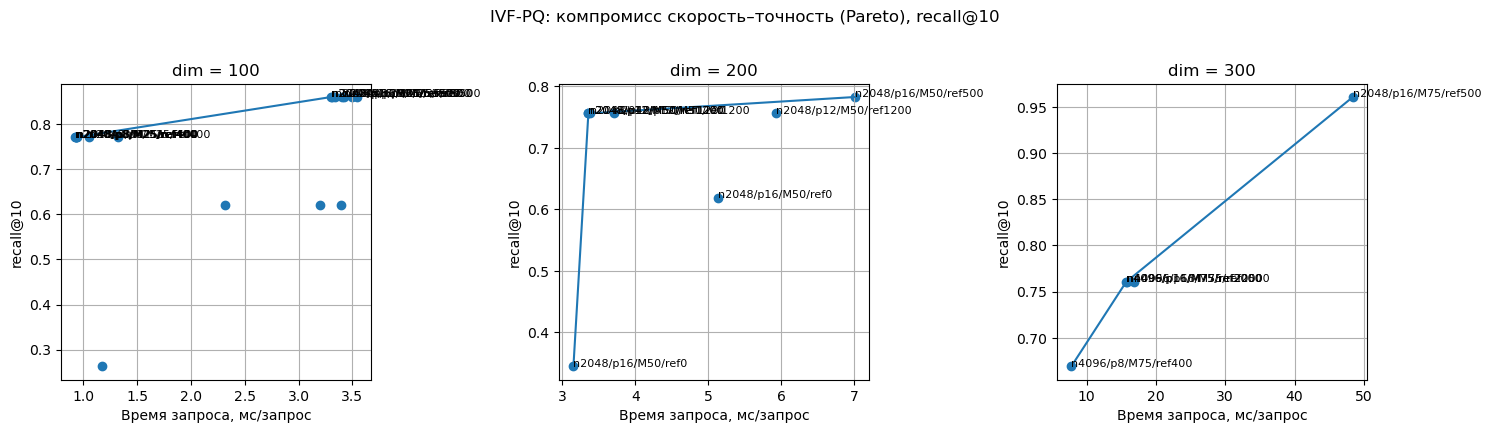

In [12]:
# =========================
# IVF-PQ plots (LoRANN-style) even if recall@k NOT stored in meta
# - loads ivfpq runs from artifacts/runs/ivfpq/**
# - loads GT from artifacts/data using dataset_id + dim
# - computes recall@k on the fly from pred_ids vs gt_ids
# - plots recall@10 vs ms/query with Pareto frontier (3 panels)
# =========================
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---- must match your dataset generation ----
N_BASE = 400_000
NQ_TEST = 20_000
TOP_K_GT = 50
SEED = 42

REPO_ROOT = Path("..").resolve()
ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()


def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        hits += len(set(pred_ids[i, :k].tolist()) & set(gt_ids[i, :k].tolist()))
    return float(hits) / float(denom) if denom > 0 else 0.0


def load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}


def load_meta_from_run(run_path: Path) -> dict:
    with np.load(run_path, allow_pickle=True) as z:
        meta = z.get("meta", None)
        md = json.loads(str(meta.item())) if meta is not None else {}
        dsid = str(z.get("dataset_id", np.array("", dtype=np.str_)).item()) if "dataset_id" in z.files else md.get("dataset_id", "")
        md["dataset_id"] = md.get("dataset_id", dsid)
        return md


_GT_CACHE = {}  # (dim, dataset_id) -> gt_ids

def load_gt_ids(dim: int, dataset_id: str) -> np.ndarray:
    key = (int(dim), str(dataset_id))
    if key in _GT_CACHE:
        return _GT_CACHE[key]

    # 1) try exact expected filename
    exact = ARTIFACTS_DATA / f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds{dataset_id}.npz"
    if exact.exists():
        gt = load_npz(exact)["gt_ids"]
        _GT_CACHE[key] = gt
        return gt

    # 2) fallback: search all GT files for that dim and check dataset_id inside
    pattern = f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds*.npz"
    candidates = sorted(ARTIFACTS_DATA.glob(pattern))
    for p in candidates:
        z = load_npz(p)
        dsid = ""
        if "dataset_id" in z:
            dsid = str(z["dataset_id"].item())
        else:
            meta = z.get("meta", None)
            if meta is not None:
                try:
                    dsid = json.loads(str(meta.item())).get("dataset_id", "")
                except Exception:
                    dsid = ""
        if dsid == dataset_id:
            gt = z["gt_ids"]
            _GT_CACHE[key] = gt
            return gt

    raise FileNotFoundError(
        f"GT not found for dim={dim}, dataset_id={dataset_id}. "
        f"Tried exact: {exact.name} and scanned {len(candidates)} candidates."
    )


def collect_ivfpq_runs():
    root = ARTIFACTS_RUNS / "ivfpq"
    if not root.exists():
        raise FileNotFoundError(f"No runs dir: {root}")

    runs = []
    for p in sorted(root.rglob("*.npz")):
        try:
            md = load_meta_from_run(p)
            if md.get("method", "ivfpq") != "ivfpq":
                # still accept, but usually it's ivfpq
                pass
            # need ms_per_query or search_seconds
            if "ms_per_query" not in md:
                # compute from search_seconds if present
                if "search_seconds" in md:
                    md["ms_per_query"] = 1000.0 * float(md["search_seconds"]) / float(NQ_TEST)
                else:
                    continue
            runs.append((p, md))
        except Exception as e:
            print("Skip bad run:", p.name, "|", e)
    return runs


def pareto_frontier(points):
    # points: list of (ms, recall)
    pts = sorted(points, key=lambda t: (t[0], -t[1]))
    best = -1.0
    front = []
    for x, y in pts:
        if y > best + 1e-12:
            front.append((x, y))
            best = y
    return front


def plot_ivfpq_pareto(dims=(100, 200, 300), k=10, show_pareto=True, annotate=12):
    runs = collect_ivfpq_runs()

    # group by dim
    by_dim = {int(d): [] for d in dims}

    for run_path, md in runs:
        d = int(md.get("dim", -1))
        if d not in by_dim:
            continue
        dsid = str(md.get("dataset_id", ""))
        if not dsid:
            continue

        # load pred_ids
        with np.load(run_path, allow_pickle=True) as z:
            pred_ids = z["pred_ids"]

        # load gt and compute recall
        gt_ids = load_gt_ids(d, dsid)
        r = recall_at_k(pred_ids, gt_ids, k=int(k))

        ms = float(md["ms_per_query"])
        by_dim[d].append((ms, float(r), md, run_path))

    plt.figure(figsize=(5 * len(dims), 4.2))
    for i, d in enumerate(dims, 1):
        d = int(d)
        plt.subplot(1, len(dims), i)

        pts = by_dim.get(d, [])
        if not pts:
            plt.title(f"dim = {d} (no runs found)")
            plt.xlabel("Время запроса, мс/запрос")
            plt.ylabel(f"recall@{k}")
            plt.grid(True)
            continue

        xs = [t[0] for t in pts]
        ys = [t[1] for t in pts]
        plt.scatter(xs, ys)

        if show_pareto:
            front = pareto_frontier([(t[0], t[1]) for t in pts])
            fx = [p[0] for p in front]
            fy = [p[1] for p in front]
            plt.plot(fx, fy)

        # annotate a handful: best recall + fastest
        if annotate and annotate > 0:
            best = sorted(pts, key=lambda t: (-t[1], t[0]))[: max(1, annotate // 2)]
            fast = sorted(pts, key=lambda t: (t[0], -t[1]))[: max(1, annotate // 2)]
            chosen = best + fast

            seen = set()
            uniq = []
            for ms, rec, md, path in chosen:
                key = (ms, rec, md.get("nlist"), md.get("nprobe"), md.get("M"), md.get("refine_r"))
                if key in seen:
                    continue
                seen.add(key)
                uniq.append((ms, rec, md))

            for ms, rec, md in uniq:
                label = f"n{md.get('nlist')}/p{md.get('nprobe')}/M{md.get('M')}/ref{md.get('refine_r')}"
                plt.annotate(label, (ms, rec), fontsize=8)

        plt.title(f"dim = {d}")
        plt.xlabel("Время запроса, мс/запрос")
        plt.ylabel(f"recall@{k}")
        plt.grid(True)

    plt.suptitle(f"IVF-PQ: компромисс скорость–точность (Pareto), recall@{k}", y=1.02)
    plt.tight_layout()
    plt.show()


# RUN
plot_ivfpq_pareto(dims=(100, 200, 300), k=10, show_pareto=True, annotate=12)


Total runs found: 31


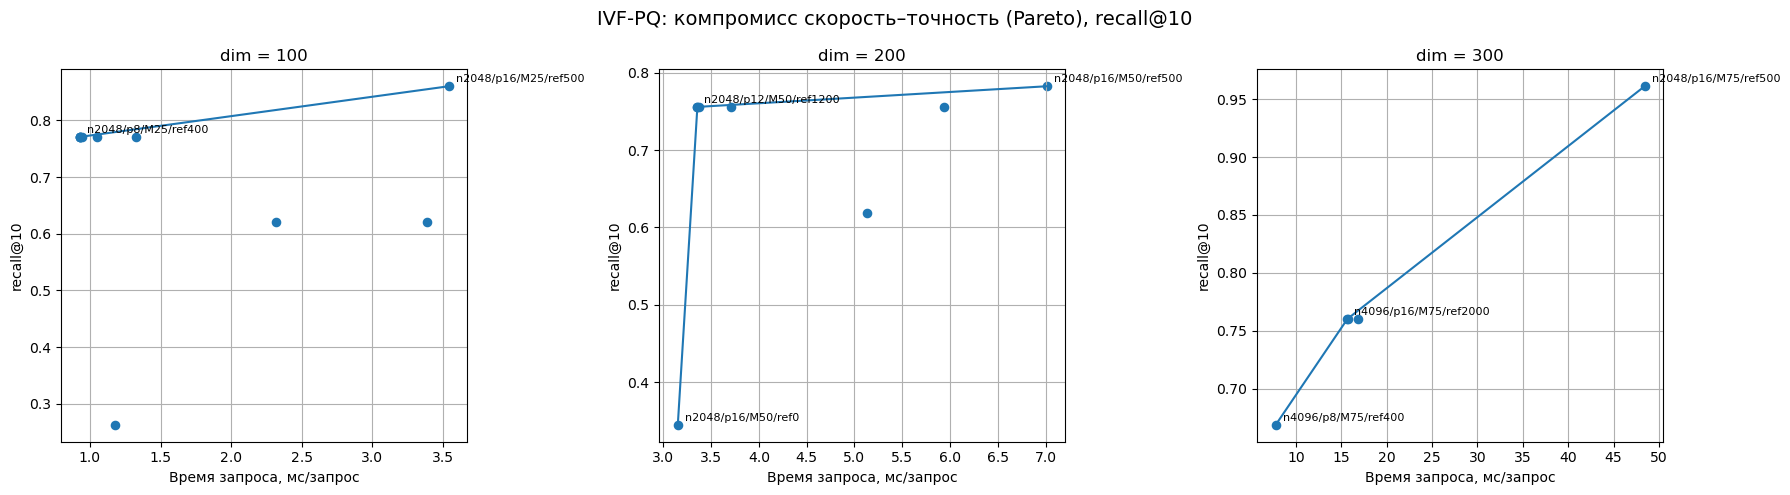

In [13]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUNS_ROOT = Path("../artifacts/runs/ivfpq").resolve()
DIMS = [100, 200, 300]
TARGET_RECALL_K = 10  # recall@10

def load_ivfpq_runs(root: Path):
    rows = []
    for p in root.rglob("*.npz"):
        try:
            z = np.load(p, allow_pickle=True)
            meta = json.loads(z["meta"].item())
        except Exception:
            continue
        if meta.get("method") != "ivfpq":
            continue
        rows.append((p, meta))
    return rows

def pareto_front(points):
    """
    points: list of (x=ms, y=recall, meta)
    Pareto for: minimize x, maximize y
    """
    pts = sorted(points, key=lambda t: (t[0], -t[1]))
    front = []
    best_y = -1e9
    for x, y, m in pts:
        if y > best_y + 1e-12:
            front.append((x, y, m))
            best_y = y
    return front

runs = load_ivfpq_runs(RUNS_ROOT)
print("Total runs found:", len(runs))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
fig.suptitle(f"IVF-PQ: компромисс скорость–точность (Pareto), recall@{TARGET_RECALL_K}", fontsize=14)

for ax, d in zip(axes, DIMS):
    pts = []
    for path, meta in runs:
        if int(meta.get("dim", -1)) != d:
            continue
        x = float(meta.get("ms_per_query", np.nan))
        y = float(meta.get(f"recall@{TARGET_RECALL_K}", np.nan))
        if not np.isfinite(x) or not np.isfinite(y):
            continue
        pts.append((x, y, meta))

    if not pts:
        ax.set_title(f"dim = {d} (no runs found)")
        ax.set_xlabel("Время запроса, мс/запрос")
        ax.set_ylabel(f"recall@{TARGET_RECALL_K}")
        ax.grid(True)
        continue

    xs = [t[0] for t in pts]
    ys = [t[1] for t in pts]
    ax.scatter(xs, ys, s=35)

    front = pareto_front(pts)
    fx = [t[0] for t in front]
    fy = [t[1] for t in front]
    ax.plot(fx, fy)

    # подпишем только точки на Pareto (и то коротко)
    for x, y, m in front:
        label = f"n{m.get('nlist')}/p{m.get('nprobe')}/M{m.get('M')}/ref{m.get('refine_r')}"
        ax.annotate(label, (x, y), textcoords="offset points", xytext=(5, 3), fontsize=8)

    ax.set_title(f"dim = {d}")
    ax.set_xlabel("Время запроса, мс/запрос")
    ax.set_ylabel(f"recall@{TARGET_RECALL_K}")
    ax.grid(True)

plt.tight_layout()
plt.show()


Total runs found: 24
Dims: [100, 200, 300]


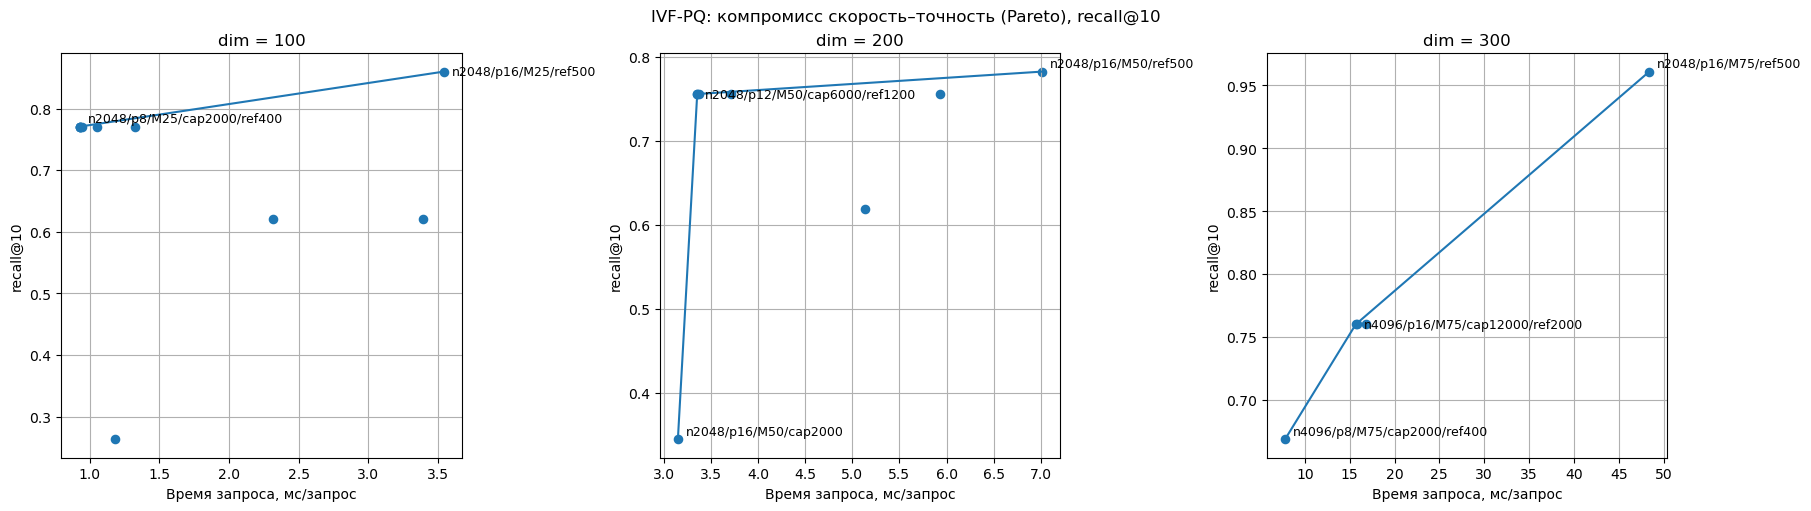

In [14]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

REPO_ROOT = Path("..").resolve()
RUNS_ROOT = (REPO_ROOT / "artifacts" / "runs" / "ivfpq").resolve()

def load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def meta_from_npz(z: dict) -> dict:
    m = z.get("meta", None)
    if m is None:
        return {}
    try:
        return json.loads(str(m.item()))
    except Exception:
        return {}

def safe_get(meta: dict, *keys, default=None):
    for k in keys:
        if k in meta:
            return meta[k]
    return default

def pareto_front(points):
    """
    points: list of (x_time, y_recall, idx)
    Return indices on Pareto front for:
      - minimize x
      - maximize y
    """
    pts = sorted(points, key=lambda t: (t[0], -t[1]))
    best_y = -1e18
    front = []
    for x, y, idx in pts:
        if y > best_y + 1e-12:
            front.append((x, y, idx))
            best_y = y
    return front

def label_for(meta: dict):
    nlist = safe_get(meta, "nlist", default=None)
    nprobe = safe_get(meta, "nprobe", default=None)
    M = safe_get(meta, "M", default=None)
    cap = safe_get(meta, "candidate_count", "cap", default=None)
    ref = safe_get(meta, "refine_r", "ref", default=None)
    parts = []
    if nlist is not None: parts.append(f"n{int(nlist)}")
    if nprobe is not None: parts.append(f"p{int(nprobe)}")
    if M is not None: parts.append(f"M{int(M)}")
    if cap is not None and int(cap) > 0: parts.append(f"cap{int(cap)}")
    if ref is not None and int(ref) > 0: parts.append(f"ref{int(ref)}")
    return "/".join(parts) if parts else "run"

# ---------- collect runs ----------
runs = []
if not RUNS_ROOT.exists():
    raise FileNotFoundError(f"Runs dir not found: {RUNS_ROOT}")

for p in sorted(RUNS_ROOT.rglob("*.npz")):
    z = load_npz(p)
    meta = meta_from_npz(z)

    dim = safe_get(meta, "dim", default=None)
    if dim is None:
        continue

    msq = safe_get(meta, "ms_per_query", default=None)
    if msq is None:
        # fallback: try compute from search_seconds and nq_test if present
        msq = safe_get(meta, "search_seconds", default=None)
        if msq is None:
            continue
        # if only total seconds, we can't safely divide without nq; skip
        continue

    # recall@10 key variants
    r10 = safe_get(meta, "recall@10", "recall_at_10", "recall10", default=None)
    if r10 is None:
        # some older metas might store dict "recalls"
        recs = safe_get(meta, "recalls", default=None)
        if isinstance(recs, dict):
            r10 = recs.get("recall@10", None)
    if r10 is None:
        continue

    runs.append({
        "path": p,
        "meta": meta,
        "dim": int(dim),
        "msq": float(msq),
        "r10": float(r10),
        "label": label_for(meta),
    })

print("Total runs found:", len(runs))
dims = sorted(set(r["dim"] for r in runs))
print("Dims:", dims)

# ---------- plot ----------
fig, axes = plt.subplots(1, len(dims), figsize=(6*len(dims), 5), constrained_layout=True)
if len(dims) == 1:
    axes = [axes]

for ax, dim in zip(axes, dims):
    sub = [r for r in runs if r["dim"] == dim]
    if not sub:
        ax.set_title(f"dim = {dim} (no runs found)")
        ax.set_xlabel("Время запроса, мс/запрос")
        ax.set_ylabel("recall@10")
        ax.grid(True)
        continue

    xs = np.array([r["msq"] for r in sub], dtype=float)
    ys = np.array([r["r10"] for r in sub], dtype=float)

    ax.scatter(xs, ys, s=35)
    ax.set_title(f"dim = {dim}")
    ax.set_xlabel("Время запроса, мс/запрос")
    ax.set_ylabel("recall@10")
    ax.grid(True)

    # Pareto front
    pts = [(r["msq"], r["r10"], i) for i, r in enumerate(sub)]
    front = pareto_front(pts)
    fx = [x for x, y, i in front]
    fy = [y for x, y, i in front]
    ax.plot(fx, fy)

    # Label ONLY front points, with simple offset to reduce overlap
    for j, (x, y, i) in enumerate(front):
        r = sub[i]
        dx = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
        dy = 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(x + dx, y + ((-1)**j)*dy, r["label"], fontsize=9)

plt.suptitle("IVF-PQ: компромисс скорость–точность (Pareto), recall@10")
plt.show()
